In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

In [2]:
us18_matches = pd.read_csv('tennis_data/2018-usopen-matches.csv')
us18_matches = us18_matches.dropna(axis=1, how='all')

us18_points = pd.read_csv('tennis_data/2018-usopen-points.csv')
us18_points = us18_points.dropna(axis=1, how='all')

In [3]:
# Get all player names from a tourney

def get_player_names(matches):
    return np.unique(np.append(matches.player1.values, matches.player2.values))

# Given a player name and tourney, get their matches
def get_player_points(player, matches, points):
    # Get all match numbers
    match_ids = matches[(matches['player1'] == player) | (matches['player2'] == player)].match_id

    player_points = points[points.match_id.isin(match_ids)]

    return player_points


def get_summary_stats(player, matches, match):
    match_metadata = matches[matches.match_id == match.loc[1].match_id]
    # Get Ace percentage for that match
    if match_metadata.player1[0] == player:
        return match.P1Ace
    else:
        return match.P2Ace

def get_serves(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_serves = player_points[(player_points.match_id.isin(p1_matches)) & (player_points.ServeIndicator == 1)]  

    p2_matches = matches[matches['player2'] == player].match_id
    p2_serves = player_points[(player_points.match_id.isin(p2_matches)) & (player_points.ServeIndicator == 2)]

    player_serves = p1_serves.append(p2_serves)
    #player_serves.reset_index()

    return player_serves

# Function for getting points that were not made by double faulting (the ball was put into play)
def get_plays(player, matches, player_points):
    plays = player_points[(player_points.P1DoubleFault == 0) & (player_points.P2DoubleFault == 0)]
    return plays

def get_net_points(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_nets = player_points[(player_points.match_id.isin(p1_matches)) & (player_points.P1NetPoint == 1)]  

    p2_matches = matches[matches['player2'] == player].match_id
    p2_nets = player_points[(player_points.match_id.isin(p2_matches)) & (player_points.P2NetPoint == 1)]

    player_nets = p1_nets.append(p2_nets)

    return player_nets

def get_distances(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_dists = player_points[(player_points.match_id.isin(p1_matches))].P1DistanceRun 

    p2_matches = matches[matches['player2'] == player].match_id
    p2_dists = player_points[(player_points.match_id.isin(p2_matches))].P2DistanceRun

    return (np.sum(p1_dists) + np.sum(p2_dists))

def get_unforced_errors(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_unf_err = player_points[(player_points.match_id.isin(p1_matches))].P1UnfErr

    p2_matches = matches[matches['player2'] == player].match_id
    p2_unf_err = player_points[(player_points.match_id.isin(p2_matches))].P2UnfErr

    return (np.sum(p1_unf_err) + np.sum(p2_unf_err))


# Given a list of players, we want to go through the entire dataset and calculate a running average of their stats
Some assumptions made by this model are that players do not significantly change their playstlye throughout this calcualtion period 2011-2020.

In [4]:
colnames = ['nServes', 'Ace_Avg', 'SSpeed', 'nPlays', 'nNets', 'Net_Avg', 'Net_Win', 'Rally_Ct', 'Unf_Err']
player_stats = pd.DataFrame(index=[''], columns=colnames)

#player_stats.loc['Roger Federer'] =  [2, 0.5]

nadal_points = get_player_points('Rafael Nadal', us18_matches, us18_points)

tours = ['ausopen', 'frenchopen', 'usopen', 'wimbledon']
players = ['Rafael Nadal']

# Triply four loop dont tell my CS profs ;(
for year in np.arange(2017, 2018):
    for tour in tours:
        matches = pd.read_csv('tennis_data/' + str(year) + '-' + tour + '-matches.csv')
        points = pd.read_csv('tennis_data/' + str(year) + '-' + tour + '-points.csv')

        players = list(set(np.append(matches.player1.values, matches.player2.values)))

        for player in players:
            player_points = get_player_points(player, matches, points)

            if player not in player_stats.index:
                player_stats.loc[player] = np.zeros(len(colnames))
            
            update_row = []

            #-----------------------------------------------------------
            # Serve Stats
            #-----------------------------------------------------------
                # Calculate running average of Aces
            player_serves = get_serves(player, matches, points)

            ace_avg = (np.sum(player_serves.P1Ace) + np.sum(player_serves.P2Ace) + player_stats.loc[player].nServes * player_stats.loc[player].Ace_Avg) \
                / (np.shape(player_serves)[0] + player_stats.loc[player].nServes)
                
            update_row.append(np.shape(player_serves)[0] + player_stats.loc[player].nServes)
            update_row.append(ace_avg)

                # Calculate running average serve speed
            serve_speed_avg = (np.sum(player_serves.Speed_MPH) + player_stats.loc[player].nServes * player_stats.loc[player].SSpeed) \
                / (np.shape(player_serves)[0] + player_stats.loc[player].nServes)

            update_row.append(serve_speed_avg)

            #-----------------------------------------------------------
            # Net Stats
            #-----------------------------------------------------------
            player_plays = get_plays(player, matches, points)
            player_nets = get_net_points(player, matches, points)
                # Calculate running average of times player played the net
            avg_net_plays = (np.sum(player_nets.P1NetPoint) + np.sum(player_nets.P2NetPoint) + player_stats.loc[player].nPlays * player_stats.loc[player].Net_Avg) \
                / (np.shape(player_plays)[0] + player_stats.loc[player].nPlays)

            avg_net_wins = (np.sum(player_nets.P1NetPointWon) + np.sum(player_nets.P2NetPointWon) + player_stats.loc[player].nNets * player_stats.loc[player].Net_Win) \
                / (np.shape(player_nets)[0] + player_stats.loc[player].nNets)


            update_row.append(np.shape(player_plays)[0] + player_stats.loc[player].nPlays)
            update_row.append(np.shape(player_nets)[0] + player_stats.loc[player].nNets)
            update_row.append(avg_net_plays)
            update_row.append(avg_net_wins)

            #-----------------------------------------------------------
            # Gameplay Stats
            #-----------------------------------------------------------
                # Avg Rally length
            avg_rally = (np.sum(player_plays.RallyCount) + player_stats.loc[player].nPlays * player_stats.loc[player].Rally_Ct) \
                / (np.shape(player_plays)[0] + player_stats.loc[player].nPlays)

            update_row.append(avg_rally)

                # Unforced error rate (consistency measure)
            player_errors = get_unforced_errors(player, matches, player_plays)
            avg_err = (player_errors + player_stats.loc[player].nPlays * player_stats.loc[player].Unf_Err) \
                / (np.shape(player_plays)[0] + player_stats.loc[player].nPlays)
            
            update_row.append(avg_err)


            player_stats.loc[player] = update_row


                # Avg distance ran during a point
            # player_dists = get_distances(player, matches, player_plays)
            # avg_dist = (player_dists + player_stats.loc[player].nPlays * player_stats.loc[player].Dists) \
                # / (np.shape(player_plays)[0] + player_stats.loc[player].nPlays)

            # update_row.append(avg_dist)


<ipython-input-4-c8fced6a0275>:33: RuntimeWarning: invalid value encountered in double_scalars
  ace_avg = (np.sum(player_serves.P1Ace) + np.sum(player_serves.P2Ace) + player_stats.loc[player].nServes * player_stats.loc[player].Ace_Avg) \
<ipython-input-4-c8fced6a0275>:40: RuntimeWarning: invalid value encountered in double_scalars
  serve_speed_avg = (np.sum(player_serves.Speed_MPH) + player_stats.loc[player].nServes * player_stats.loc[player].SSpeed) \
<ipython-input-4-c8fced6a0275>:54: RuntimeWarning: invalid value encountered in double_scalars
  avg_net_wins = (np.sum(player_nets.P1NetPointWon) + np.sum(player_nets.P2NetPointWon) + player_stats.loc[player].nNets * player_stats.loc[player].Net_Win) \


In [5]:
player_stats = player_stats.dropna()
player_stats

,nServes,Ace_Avg,SSpeed,nPlays,nNets,Net_Avg,Net_Win,Rally_Ct,Unf_Err
Gilles Muller,1071.0,0.154062,99.634921,156179.0,290.0,0.001857,0.751724,3.373924,0.001428
Kiki Bertens,315.0,0.050794,33.907937,127448.0,42.0,0.000330,0.690476,3.182059,0.000957
Yulia Putintseva,501.0,0.017964,50.744511,156179.0,40.0,0.000256,0.800000,3.373924,0.001153
Jana Cepelova,247.0,0.008097,61.465587,156179.0,24.0,0.000154,0.750000,3.373924,0.000608
Donna Vekic,402.0,0.049751,56.266169,114731.0,44.0,0.000384,0.727273,3.477194,0.000994
...,...,...,...,...,...,...,...,...,...
Brydan Klein,90.0,0.066667,0.000000,44020.0,19.0,0.000432,0.842105,2.930986,0.000363
Marton Fucsovics,99.0,0.121212,96.222222,44020.0,13.0,0.000295,0.692308,2.930986,0.000273
Vasek Pospisil,106.0,0.066038,107.264151,44020.0,38.0,0.000863,0.605263,2.930986,0.000341
Xinyun Han,52.0,0.000000,0.000000,44020.0,17.0,0.000386,0.823529,2.930986,0.000409


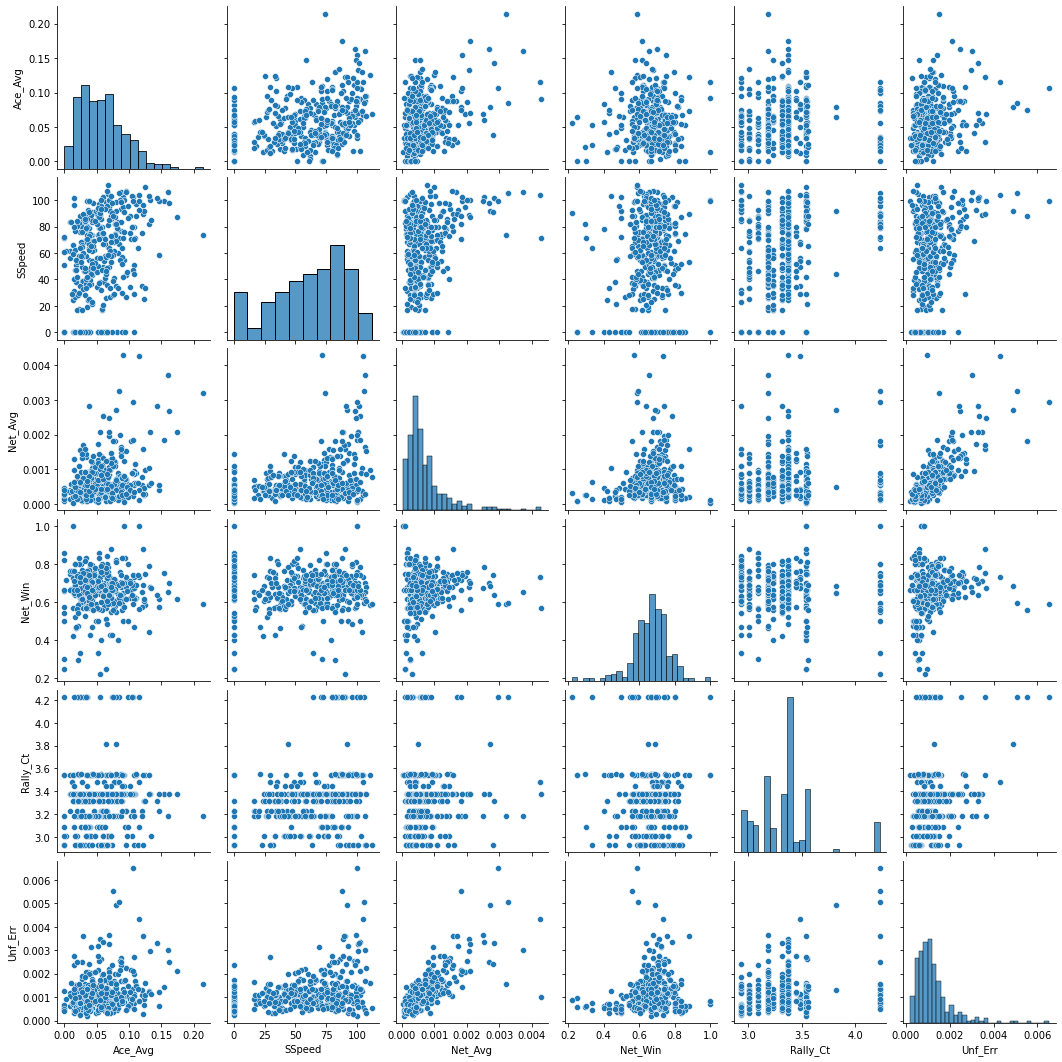

In [6]:
predictors = ['Ace_Avg', 'SSpeed', 'Net_Avg', 'Net_Win', 'Rally_Ct', 'Unf_Err']

player_stats_preds = player_stats[predictors]

sns.pairplot(player_stats_preds)

# Clustering

In [26]:
scaler = StandardScaler()
player_stats_scaled = scaler.fit_transform(player_stats_preds)

inertias = []

K = range(1,20)

for k in K:
    km = KMeans(
        init='random',
        n_clusters=k,
        n_init=10,
        max_iter=300,
        random_state=98
    )

    km = km.fit(player_stats_scaled)
    inertias.append(km.inertia_)

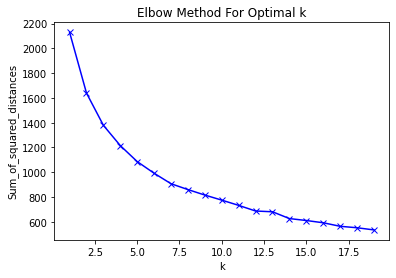

In [27]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Well that elbow plot isn't very encouragin, lets try some PCA?

- Look into Silhouette value for evaluating kmeans clustering

# Trying PCA

In [28]:
pca = decomposition.PCA()

pca.fit(player_stats_scaled)
PCA_components = pca.transform(player_stats_scaled)

In [29]:
pca.explained_variance_ratio_

array([0.39020453, 0.18158289, 0.16119268, 0.1379625 , 0.09582218,
       0.03323522])

Text(0, 0.5, 'PCA 2')

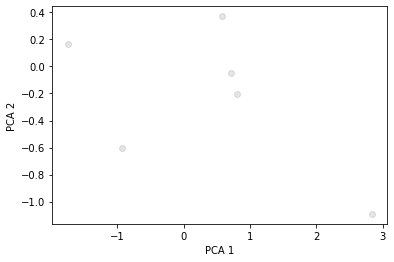

In [30]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

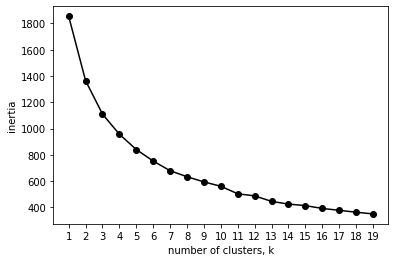

In [33]:
inertias = []

K = range(1,20)

for k in K:
    km = KMeans(
        init='random',
        n_clusters=k,
        n_init=10,
        max_iter=300,
        random_state=98
    )

    km = km.fit(PCA_components[:,:4])
    inertias.append(km.inertia_)


plt.plot(K, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(K)
plt.show()